In [7]:
%matplotlib inline
import numpy as np
import pandas as pd
import bs4 as bs
import os, sys, re
import nltk

In [8]:
books = []
folder = os.listdir("./data")
for i in folder:
    book = open("./data/"+i).read()
    books.append(book) # combine all texts to 1 text

In [9]:
stopwords = nltk.corpus.stopwords.words('english')
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("english")

In [10]:
def tokenize_and_stem(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    stems = [stemmer.stem(t) for t in filtered_tokens]
    return stems

def tokenize_only(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    return filtered_tokens

totalvocab_stemmed = []
totalvocab_tokenized = []
for book in books:
    text = book.decode("utf-8").strip()
    allwords_stemmed = tokenize_and_stem(text)
    totalvocab_stemmed.extend(allwords_stemmed)
    
    allwords_tokenized = tokenize_only(text)
    totalvocab_tokenized.extend(allwords_tokenized)

In [11]:
vocab_frame = pd.DataFrame({'words': totalvocab_tokenized}, index = totalvocab_stemmed)

In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(max_df=0.9, max_features=300000,
                                 min_df=0.1, stop_words='english',
                                 use_idf=True, tokenizer=tokenize_and_stem, ngram_range=(1,1))

%time tfidf_matrix = tfidf_vectorizer.fit_transform(books)

print(tfidf_matrix.shape)

CPU times: user 2min 24s, sys: 374 ms, total: 2min 24s
Wall time: 2min 24s
(24, 34645)


In [13]:
terms = tfidf_vectorizer.get_feature_names()
from sklearn.metrics.pairwise import cosine_similarity
dist = 1 - cosine_similarity(tfidf_matrix)

In [14]:
from sklearn.cluster import KMeans

num_clusters = 5

km = KMeans(n_clusters=num_clusters)

%time km.fit(tfidf_matrix)

clusters = km.labels_.tolist()

CPU times: user 13.5 s, sys: 534 ms, total: 14.1 s
Wall time: 2.37 s


In [15]:
from sklearn.externals import joblib
# joblib.dump(km,  'doc_cluster.pkl')
km = joblib.load('doc_cluster.pkl')
clusters = km.labels_.tolist()

In [16]:
def map_book_name(book):
    books = {
        'gap_2X5KAAAAYAAJ': 'CorneliusTacitus-1',
        'gap_MEoWAAAAYAAJ': 'CorneliusTacitus-2',
        'gap_pX5KAAAAYAAJ': 'CorneliusTacitus-3',
        'gap_WORMAAAAYAAJ': 'CorneliusTacitus-4',

        'gap_9ksIAAAAQAAJ': 'PeloponnesianWar-1',
        'gap_fnAMAAAAYAAJ': 'PeloponnesianWar-2',
        'gap_DhULAAAAYAAJ': 'TheDescriptionOfGreece-1',

        'gap_aLcWAAAAQAAJ': 'RomanEmpire-1',
        'gap_CSEUAAAAYAAJ': 'RomanEmpire-2',
        'gap_GIt0HMhqjRgC': 'RomanEmpire-3',
        'gap_IlUMAQAAMAAJ': 'RomanEmpire-4',
        'gap_XmqHlMECi6kC': 'RomanEmpire-5',
        'gap_VPENAAAAQAAJ': 'RomanEmpire-6',

        'gap_Bdw_AAAAYAAJ': 'HistoryOfRome-Titus-Livius-1',
        'gap_m_6B1DkImIoC': 'HistoryOfRome-Titus-Livius-2',
        'gap_DqQNAAAAYAAJ': 'HistoryOfRome-Livy-1',
        'gap_RqMNAAAAYAAJ': 'HistoryOfRome-Livy-2',

        'gap_CnnUAAAAMAAJ': 'Josephus-1',
        'gap_ogsNAAAAIAAJ': 'Josephus-2',
        'gap_TgpMAAAAYAAJ': 'Josephus-3',
        'gap_y-AvAAAAYAAJ': 'Josephus-4',

        'gap_-C0BAAAAQAAJ': 'DictionaryOfGreekAndRomanGeography',
        'gap_dIkBAAAAQAAJ': 'HistoryOfRome-1',
        'gap_udEIAAAAQAAJ': 'NaturalHistoryOfPliny-1',
    }

    return books[book]

In [17]:
titles = []
for i in folder:
    titles.append(map_book_name(i[:-4]))

In [18]:
books_collection = { 'title': titles, 'books': books, 'cluster': clusters}

In [19]:
frame = pd.DataFrame(books_collection, index = [clusters] , columns = ['title', 'cluster'])
frame['cluster'].value_counts()

4    6
1    6
0    5
2    4
3    3
Name: cluster, dtype: int64

In [20]:
from __future__ import print_function

print("Top terms per cluster:")
#sort cluster centers by proximity to centroid
order_centroids = km.cluster_centers_.argsort()[:, ::-1] 

for i in range(5):
    print("Cluster %d words:" % i, end='')
    
    for ind in order_centroids[i, :6]: #replace 6 with n words per cluster
        print(' %s' % vocab_frame.ix[terms[ind].split(' ')].values.tolist()[0][0].encode('utf-8', 'ignore'), end=',')
        print()
    print("Cluster %d titles:" % i, end='')
    for title in frame.ix[i]['title'].values.tolist():
        print(' %s,' % title, end='')
        print()

Top terms per cluster:
Cluster 0 words:

/home/neunberg/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  # This is added back by InteractiveShellApp.init_path()


 consuls,
 chap,
 sulla,
 thefe,
 samnites,
 lucius,
Cluster 0 titles: HistoryOfRome-Titus-Livius-2,
 HistoryOfRome-1,
 HistoryOfRome-Livy-2,
 HistoryOfRome-Livy-1,
 HistoryOfRome-Titus-Livius-1,
Cluster 1 words: emperor,
 justinian,


/home/neunberg/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:14: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  


 chap,
 lib,
 torn,
 christian,
Cluster 1 titles: RomanEmpire-6,
 RomanEmpire-3,
 RomanEmpire-2,
 RomanEmpire-1,
 RomanEmpire-5,
 RomanEmpire-4,
Cluster 2 words: jews,
 herod,
 josephus,
 jerusalem,
 chap,
 hyrcanus,
Cluster 2 titles: Josephus-2,
 Josephus-4,
 Josephus-1,
 Josephus-3,
Cluster 3 words: athenians,
 peloponnesians,
 fay,
 lacedaemonians,
 syracusans,
 argives,
Cluster 3 titles: PeloponnesianWar-1,
 TheDescriptionOfGreece-1,
 PeloponnesianWar-2,
Cluster 4 words: s.,
 nero,
 et,
 tacitus,
 legion,
 cf,
Cluster 4 titles: CorneliusTacitus-1,
 DictionaryOfGreekAndRomanGeography,
 CorneliusTacitus-3,
 CorneliusTacitus-2,
 NaturalHistoryOfPliny-1,
 CorneliusTacitus-4,


In [21]:
import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn.manifold import MDS

MDS()

# convert two components as we're plotting points in a two-dimensional plane
# "precomputed" because we provide a distance matrix
# we will also specify `random_state` so the plot is reproducible.
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)

pos = mds.fit_transform(dist)  # shape (n_components, n_samples)

xs, ys = pos[:, 0], pos[:, 1]

#set up cluster names using a dict
cluster_names = {0: 'consuls, samnites', 
                 1: 'emperor, christian', 
                 2: 'jews, jerusalem', 
                 3: 'athenians, peloponnesians', 
                 4: 'tacitus, legion'}

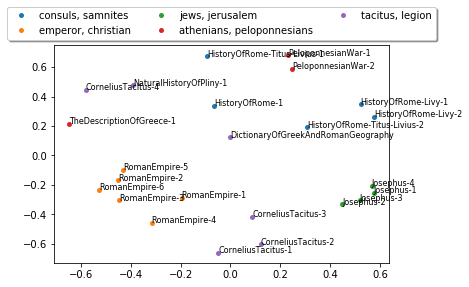

In [28]:
#create data frame that has the result of the MDS plus the cluster numbers and titles
df = pd.DataFrame(dict(x=xs, y=ys, label=clusters, title=titles)) 

#group by cluster
groups = df.groupby('label')


# set up plot
fig, ax = plt.subplots() # set size
# ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

#iterate through groups to layer the plot
#note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=5, 
            label=cluster_names[name], 
            mec='none')
#     ax.set_aspect('auto')
#     ax.tick_params(\
#         axis= 'x',          # changes apply to the x-axis
#         which='both',      # both major and minor ticks are affected
#         bottom='off',      # ticks along the bottom edge are off
#         top='off',         # ticks along the top edge are off
#         labelbottom='off')
#     ax.tick_params(\
#         axis= 'y',         # changes apply to the y-axis
#         which='both',      # both major and minor ticks are affected
#         left='off',      # ticks along the bottom edge are off
#         top='off',         # ticks along the top edge are off
#         labelleft='off')
    
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.2),
          ncol=3, fancybox=True, shadow=True)  #show legend with only 1 point

#add label in x,y position with the label as the film title
for i in range(len(df)):
    ax.text(df.loc[i]['x'], df.loc[i]['y'], df.loc[i]['title'], size=8)  

plt.show()

In [29]:
# plt.savefig('clusters.png', dpi=200)

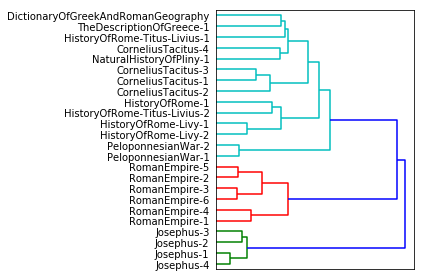

In [23]:
from scipy.cluster.hierarchy import ward, dendrogram

linkage_matrix = ward(dist) #define the linkage_matrix using ward clustering pre-computed distances

fig, ax = plt.subplots() # set size
ax = dendrogram(linkage_matrix, orientation="right", labels=titles);

plt.tick_params(\
    axis= 'x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    labelbottom='off')

plt.tight_layout() #show plot with tight layout

#uncomment below to save figure
# plt.savefig('ward_clusters.png', dpi=200) #save figure as ward_clusters